C:\Users\david\AppData\Local\Temp\ipykernel_11668\1511047104.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\david\AppData\Local\Temp\ipykernel_11668\1511047104.py:114: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pivot


Scores guardados en: ./scores_emisiones_pib.csv


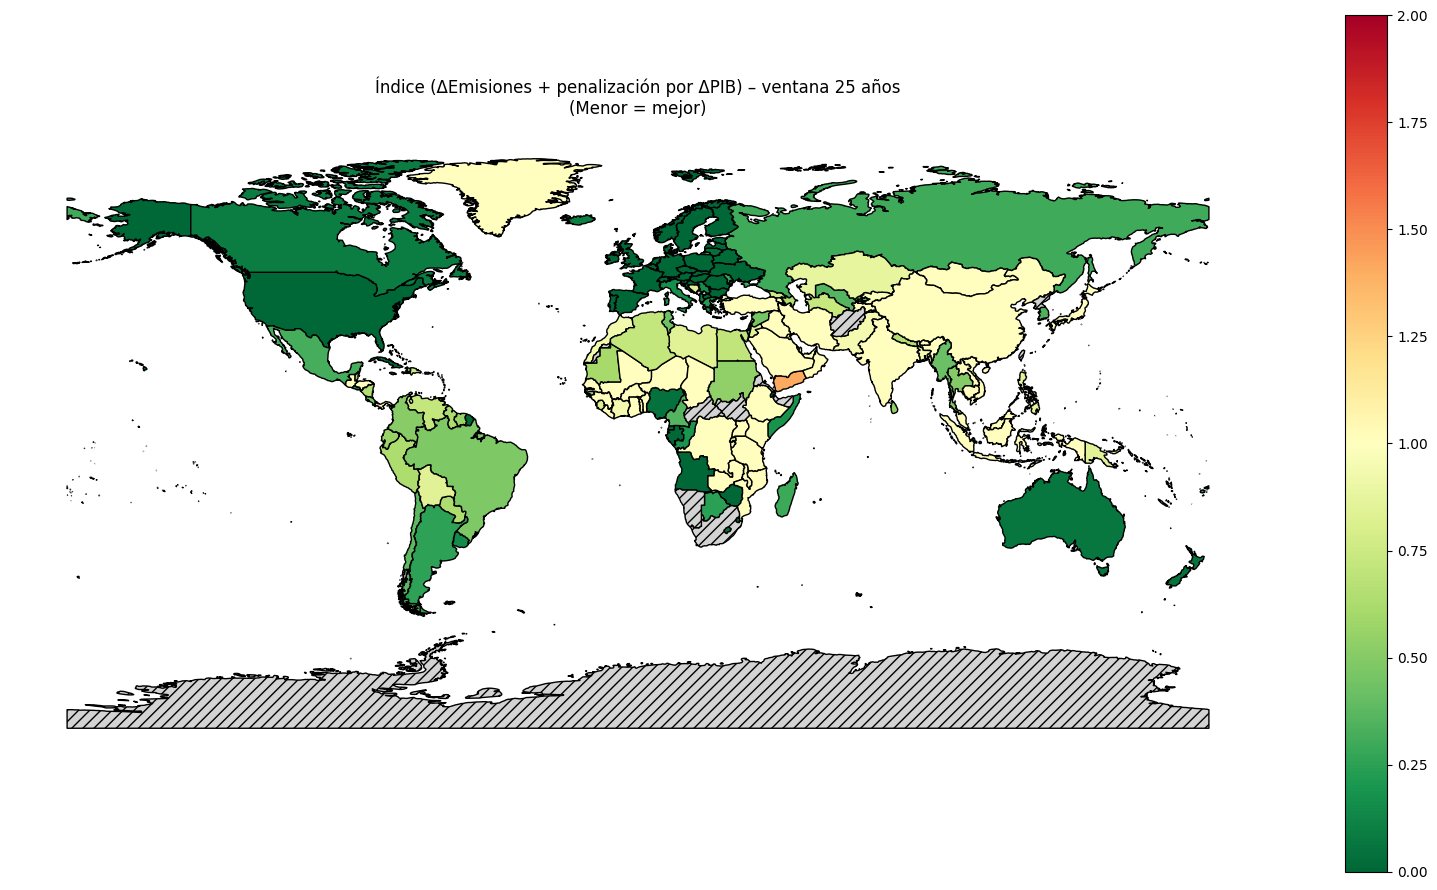

In [2]:
import os
import numpy as np
import pandas as pd
import pymysql
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry
from dotenv import load_dotenv

# =========================
# Parámetros del análisis
# =========================
N = 25              # ventana de años (ej. 10, 20)
CLIP = True         # recortar componentes a [0,1]
SHAPEFILE = "./../../data/visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"

# Suavizados por si hubiera ceros (raro en PIB, pero por robustez)
EPS_EMI = 0.0
EPS_GDP = 1.0

# =========================
# Conexión a la base de datos
# =========================
load_dotenv()
conn = pymysql.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)

# =========================
# 1) Traer emisiones y PIB
#    (ajusta los códigos si en tu BD son distintos)
# =========================
query = """
SELECT 
    h.anio,
    p.codigo              AS iso2,
    p.nombre              AS pais_nombre,
    i.codigo              AS indicador_codigo,
    h.valor               AS valor
FROM hechos h
JOIN paises p      ON p.codigo = h.pais_id
JOIN indicadores i ON i.id = h.indicador_id
WHERE i.codigo IN ('emision_co2', 'NY.GDP.MKTP.CD')  -- emisiones y PIB nominal USD
"""
df = pd.read_sql(query, conn)

# =========================
# 2) Pivot: una fila por país-año
# =========================
df_pivot = df.pivot_table(
    index=["anio", "iso2", "pais_nombre"],
    columns="indicador_codigo",
    values="valor",
    aggfunc="mean"
).reset_index()

df_pivot.rename(columns={
    "anio": "Year",
    "emision_co2": "Emisiones",
    "NY.GDP.MKTP.CD": "PIB"
}, inplace=True)

# Asegúrate de tener ambos indicadores en los años usados
df_pivot = df_pivot.dropna(subset=["Emisiones", "PIB"])

# =========================
# 3) Cálculo del score por país
# =========================
def clip01(x):
    return max(0.0, min(1.0, x))

def frac_change(end, start, eps=0.0):
    """Cambio relativo en fracción, robusto a ceros: (end+eps)/(start+eps) - 1"""
    return (end + eps) / (start + eps) - 1

def score_pais(g):
    y_end = g["Year"].max()
    y_start = y_end - (N - 1)
    g_win = g[g["Year"].between(y_start, y_end)]

    # Requiere ambos extremos
    if not ((g_win["Year"] == y_start).any() and (g_win["Year"] == y_end).any()):
        return pd.Series({"Score": np.nan, "YearStart": y_start, "YearEnd": y_end})

    E0  = g_win.loc[g_win["Year"] == y_start, "Emisiones"].mean()
    E1  = g_win.loc[g_win["Year"] == y_end,   "Emisiones"].mean()
    G0  = g_win.loc[g_win["Year"] == y_start, "PIB"].mean()
    G1  = g_win.loc[g_win["Year"] == y_end,   "PIB"].mean()

    if pd.isna(E0) or pd.isna(E1) or pd.isna(G0) or pd.isna(G1):
        return pd.Series({"Score": np.nan, "YearStart": y_start, "YearEnd": y_end})

    # Emisiones: subidas => malo (penalizan)
    e = frac_change(E1, E0, eps=EPS_EMI)

    # PIB: subidas => bueno (no penalizan); invertimos
    gdp_growth = frac_change(G1, G0, eps=EPS_GDP)

    if CLIP:
        e = clip01(e)                     # 0..1 (0 mejor, 1 peor)
        g_comp = 1 - clip01(gdp_growth)   # 1 peor (sin crecimiento), 0 mejor (>=100% crecimiento)
    else:
        # Sin clip: asegura al menos el acotado final
        e = max(0.0, e)
        g_comp = max(0.0, 1 - gdp_growth)

    score = e + g_comp     # 0..2 (menor = mejor)
    return pd.Series({"Score": score, "YearStart": y_start, "YearEnd": y_end})

df_scores = (
    df_pivot
    .groupby(["iso2", "pais_nombre"], as_index=False)
    .apply(score_pais)
)

# También útil en 0..100
df_scores["Score_0_100"] = 50 * df_scores["Score"]

# =========================
# 4) Códigos ISO3 para el mapa
# =========================
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df_scores["iso_a3"] = df_scores["iso2"].apply(iso2_to_iso3)
df_scores = df_scores[df_scores["iso_a3"].notna()].copy()
df_scores["iso_a3"] = df_scores["iso_a3"].str.upper()

# Guardar CSV para Power BI u otros usos
out_csv = "./scores_emisiones_pib.csv"
df_scores.to_csv(out_csv, index=False)
print(f"Scores guardados en: {out_csv}")

# =========================
# 5) Mapa mundial (merge robusto)
# =========================
world = gpd.read_file(SHAPEFILE)

# Toma la mejor clave disponible del shapefile
shape_key_candidates = ["ADM0_A3", "ISO_A3_EH", "ISO_A3"]
for k in shape_key_candidates:
    if k in world.columns:
        shape_key = k
        break
world[shape_key] = world[shape_key].astype(str).str.upper()

# Merge
map_data = world.merge(df_scores, left_on=shape_key, right_on="iso_a3", how="left")

# Diagnóstico rápido (opcional): quién no casó
world_codes = set(world[shape_key].unique())
unmatched = (
    df_scores[~df_scores["iso_a3"].isin(world_codes)]
    [["iso2","pais_nombre","iso_a3"]]
    .drop_duplicates()
    .sort_values("pais_nombre")
)
if len(unmatched):
    print("Códigos sin match en el shapefile:")
    print(unmatched.head(30))

# =========================
# 6) Pintar (verde→rojo, 0..2)
# =========================
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title(f"Índice (ΔEmisiones + penalización por ΔPIB) – ventana {N} años\n(Menor = mejor)", pad=12)

map_data.plot(
    column="Score",
    legend=True,
    ax=ax,
    edgecolor="black",
    cmap="RdYlGn_r",   # verde (mejor) → rojo (peor)
    vmin=0, vmax=2,
    missing_kwds={"color": "lightgrey", "hatch": "///", "label": "Sin datos"},
)

ax.axis("off")
plt.tight_layout()
plt.show()


PIB GRAFICA

C:\Users\david\AppData\Local\Temp\ipykernel_11668\318412924.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


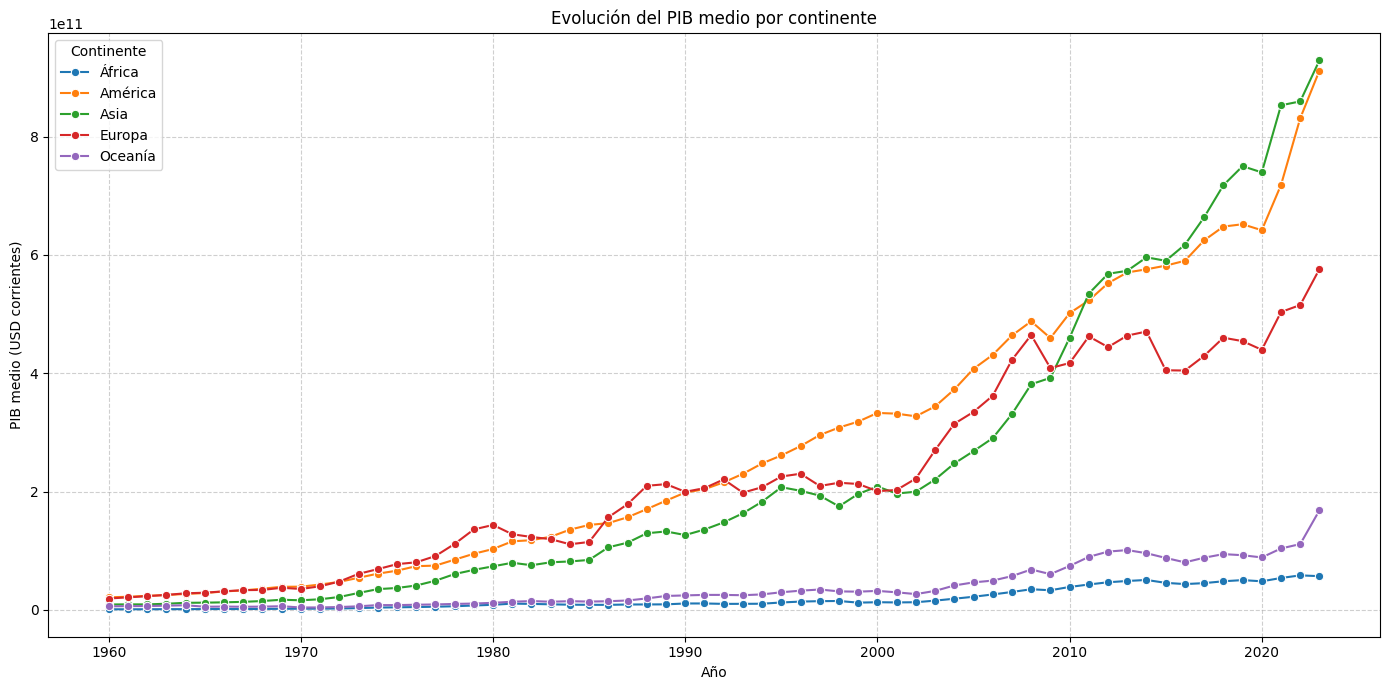

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

query = """
SELECT 
    h.anio,
    c.nombre AS continente,
    AVG(h.valor) AS pib_medio
FROM hechos h
JOIN paises p      ON h.pais_id = p.codigo
JOIN continentes c ON p.continente_id = c.id
JOIN indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'NY.GDP.MKTP.CD'
GROUP BY h.anio, c.nombre
ORDER BY h.anio, c.nombre;
"""

df = pd.read_sql(query, conn)

plt.figure(figsize=(14,7))
sns.lineplot(
    data=df,
    x="anio",
    y="pib_medio",
    hue="continente",
    marker="o"
)

plt.title("Evolución del PIB medio por continente")
plt.xlabel("Año")
plt.ylabel("PIB medio (USD corrientes)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Continente")
plt.tight_layout()
plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_11668\3741673349.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


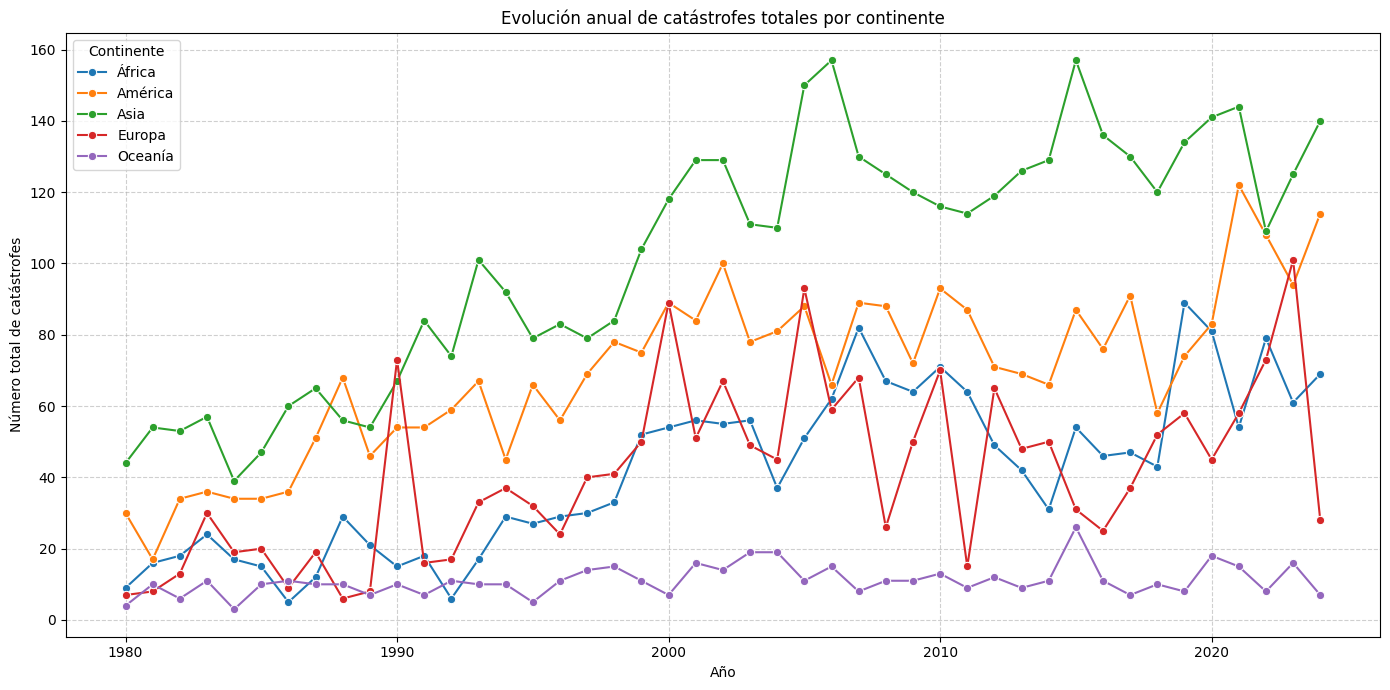

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

query = """
SELECT 
    h.anio,
    c.nombre AS continente,
    SUM(h.valor) AS desastres_totales
FROM hechos h
JOIN paises p      ON h.pais_id = p.codigo
JOIN continentes c ON p.continente_id = c.id
JOIN indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'desastres_total'
GROUP BY h.anio, c.nombre
ORDER BY h.anio, c.nombre;
"""

df = pd.read_sql(query, conn)

plt.figure(figsize=(14,7))
sns.lineplot(
    data=df,
    x="anio",
    y="desastres_totales",
    hue="continente",
    marker="o"
)

plt.title("Evolución anual de catástrofes totales por continente")
plt.xlabel("Año")
plt.ylabel("Número total de catástrofes")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Continente")
plt.tight_layout()
plt.show()
